Import necessary libraries

In [1]:
'''
#Train a simple deep CNN on the CIFAR10 small images dataset.
It gets to 75% validation accuracy in 25 epochs, and 79% after 50 epochs.
(it's still underfitting at that point, though).
'''
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os


Load data and set the parameters

In [2]:
batch_size = 512
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Generate the model

In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Train the model

In [4]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
  print('Not using data augmentation.')
  model.fit(x_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(x_test, y_test),
      shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
  Fit_CNN = model.fit_generator(datagen.flow(x_train, y_train,
                  batch_size=batch_size),
            epochs=epochs,
            validation_data=(x_test, y_test),
            workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/706324705.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_CNN = model.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 18s 180ms/step - loss: 2.1148 - accuracy: 0.2147 - val_loss: 1.9228 - val_accuracy: 0.3185
Epoch 2/10
98/98 [==============================] - 18s 185ms/step - loss: 1.8939 - accuracy: 0.3105 - val_loss: 1.7690 - val_accuracy: 0.3762
Epoch 3/10
98/98 [==============================] - 18s 183ms/step - loss: 1.7932 - accuracy: 0.3483 - val_loss: 1.6851 - val_accuracy: 0.4041
Epoch 4/10
98/98 [==============================] - 18s 186ms/step - loss: 1.7360 - accuracy: 0.3714 - val_loss: 1.6770 - val_accuracy: 0.4056
Epoch 5/10
98/98 [==============================] - 19s 187ms/step - loss: 1.6903 - accuracy: 0.3838 - val_loss: 1.5738 - val_accuracy: 0.4287
Epoch 6/10
98/98 [==============================] - 18s 186ms/step - loss: 1.6542 - accuracy: 0.4003 - val_loss: 1.5551 - val_accuracy: 0.4390
Epoch 7/10
98/98 [==============================] - 19s 189ms/step - loss: 1.6203 - accuracy: 0.4125 - val_loss: 1.4825 - val_accuracy: 0.4660
Epoch 8/10

Save model and weights

In [5]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/yipengwei/Downloads/saved_models/keras_cifar10_trained_model.h5 


/Users/yipengwei/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Score trained model.

In [6]:
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 2s 6ms/step - loss: 1.4104 - accuracy: 0.4932
Test loss: 1.4104069471359253
Test accuracy: 0.49320000410079956


In [7]:
'''
Hidden Layer 0
'''
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_hidden_layer_0 = Sequential()
model_hidden_layer_0.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_layer_0.add(Dense(num_classes))
model_hidden_layer_0.add(Activation('softmax'))

In [8]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_hidden_layer_0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_hidden_layer_0.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_hidden_layer_0 = model_hidden_layer_0.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/653228409.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_hidden_layer_0 = model_hidden_layer_0.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 6s 58ms/step - loss: 2.1861 - accuracy: 0.1873 - val_loss: 2.0490 - val_accuracy: 0.2712
Epoch 2/10
98/98 [==============================] - 6s 58ms/step - loss: 2.0247 - accuracy: 0.2779 - val_loss: 1.9656 - val_accuracy: 0.3079
Epoch 3/10
98/98 [==============================] - 6s 54ms/step - loss: 1.9721 - accuracy: 0.3005 - val_loss: 1.9229 - val_accuracy: 0.3224
Epoch 4/10
98/98 [==============================] - 6s 55ms/step - loss: 1.9437 - accuracy: 0.3150 - val_loss: 1.8998 - val_accuracy: 0.3402
Epoch 5/10
98/98 [==============================] - 6s 59ms/step - loss: 1.9244 - accuracy: 0.3223 - val_loss: 1.8771 - val_accuracy: 0.3418
Epoch 6/10
98/98 [==============================] - 6s 57ms/step - loss: 1.9082 - accuracy: 0.3299 - val_loss: 1.8638 - val_accuracy: 0.3508
Epoch 7/10
98/98 [==============================] - 5s 54ms/step - loss: 1.9003 - accuracy: 0.3318 - val_loss: 1.8570 - val_accuracy: 0.3503
Epoch 8/10
98/98 [======

In [9]:
'''
Hidden Layer 1
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model_hidden_layer_1 = Sequential()
model_hidden_layer_1.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_layer_1.add(Dense(512))
model.add(Activation('relu'))
model_hidden_layer_1.add(Dropout(0.5))
model_hidden_layer_1.add(Dense(num_classes))
model_hidden_layer_1.add(Activation('softmax'))

In [10]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_hidden_layer_1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_hidden_layer_1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_hidden_layer_1 = model_hidden_layer_1.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/3955281147.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_hidden_layer_1 = model_hidden_layer_1.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 6s 63ms/step - loss: 2.4224 - accuracy: 0.1957 - val_loss: 2.0419 - val_accuracy: 0.3012
Epoch 2/10
98/98 [==============================] - 6s 61ms/step - loss: 2.1895 - accuracy: 0.2501 - val_loss: 2.1526 - val_accuracy: 0.3024
Epoch 3/10
98/98 [==============================] - 6s 64ms/step - loss: 2.1425 - accuracy: 0.2656 - val_loss: 2.1394 - val_accuracy: 0.3036
Epoch 4/10
98/98 [==============================] - 7s 67ms/step - loss: 2.1063 - accuracy: 0.2786 - val_loss: 2.0473 - val_accuracy: 0.3001
Epoch 5/10
98/98 [==============================] - 6s 63ms/step - loss: 2.0808 - accuracy: 0.2801 - val_loss: 1.9767 - val_accuracy: 0.3242
Epoch 6/10
98/98 [==============================] - 7s 65ms/step - loss: 2.0598 - accuracy: 0.2857 - val_loss: 1.9434 - val_accuracy: 0.3141
Epoch 7/10
98/98 [==============================] - 7s 61ms/step - loss: 2.0470 - accuracy: 0.2915 - val_loss: 1.9888 - val_accuracy: 0.3080
Epoch 8/10
98/98 [======

In [11]:
'''
Hidden Layer 2
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model_hidden_layer_2 = Sequential()
model_hidden_layer_2.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_layer_2.add(Dense(512))
model_hidden_layer_2.add(Activation('relu'))
model_hidden_layer_2.add(Dropout(0.5))
model_hidden_layer_2.add(Dense(512))
model_hidden_layer_2.add(Activation('relu'))
model_hidden_layer_2.add(Dropout(0.5))
model_hidden_layer_2.add(Dense(num_classes))
model_hidden_layer_2.add(Activation('softmax'))

In [12]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_hidden_layer_2.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_hidden_layer_2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_hidden_layer_2 = model_hidden_layer_2.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/3875659683.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_hidden_layer_2 = model_hidden_layer_2.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 7s 72ms/step - loss: 2.1654 - accuracy: 0.2036 - val_loss: 1.9536 - val_accuracy: 0.3182
Epoch 2/10
98/98 [==============================] - 7s 67ms/step - loss: 2.0124 - accuracy: 0.2644 - val_loss: 1.8622 - val_accuracy: 0.3519
Epoch 3/10
98/98 [==============================] - 7s 64ms/step - loss: 1.9503 - accuracy: 0.2934 - val_loss: 1.8033 - val_accuracy: 0.3628
Epoch 4/10
98/98 [==============================] - 7s 64ms/step - loss: 1.9084 - accuracy: 0.3137 - val_loss: 1.7689 - val_accuracy: 0.3883
Epoch 5/10
98/98 [==============================] - 7s 67ms/step - loss: 1.8783 - accuracy: 0.3241 - val_loss: 1.7484 - val_accuracy: 0.3817
Epoch 6/10
98/98 [==============================] - 7s 69ms/step - loss: 1.8595 - accuracy: 0.3318 - val_loss: 1.7341 - val_accuracy: 0.3957
Epoch 7/10
98/98 [==============================] - 7s 66ms/step - loss: 1.8375 - accuracy: 0.3383 - val_loss: 1.7180 - val_accuracy: 0.3962
Epoch 8/10
98/98 [======

In [13]:
'''
Hidden Layer 3
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model_hidden_layer_3 = Sequential()
model_hidden_layer_3.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_layer_3.add(Dense(512))
model_hidden_layer_3.add(Activation('relu'))
model_hidden_layer_3.add(Dropout(0.5))
model_hidden_layer_3.add(Dense(512))
model_hidden_layer_3.add(Activation('relu'))
model_hidden_layer_3.add(Dropout(0.5))
model_hidden_layer_3.add(Dense(512))
model_hidden_layer_3.add(Activation('relu'))
model_hidden_layer_3.add(Dropout(0.5))
model_hidden_layer_3.add(Dense(num_classes))
model_hidden_layer_3.add(Activation('softmax'))

In [14]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_hidden_layer_3.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_hidden_layer_3.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_hidden_layer_3 = model_hidden_layer_3.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/1377716968.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_hidden_layer_3 = model_hidden_layer_3.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 7s 68ms/step - loss: 2.2379 - accuracy: 0.1579 - val_loss: 2.0434 - val_accuracy: 0.2797
Epoch 2/10
98/98 [==============================] - 7s 69ms/step - loss: 2.0847 - accuracy: 0.2192 - val_loss: 1.9492 - val_accuracy: 0.3158
Epoch 3/10
98/98 [==============================] - 7s 69ms/step - loss: 2.0171 - accuracy: 0.2542 - val_loss: 1.8865 - val_accuracy: 0.3354
Epoch 4/10
98/98 [==============================] - 7s 68ms/step - loss: 1.9707 - accuracy: 0.2781 - val_loss: 1.8342 - val_accuracy: 0.3553
Epoch 5/10
98/98 [==============================] - 7s 66ms/step - loss: 1.9401 - accuracy: 0.2921 - val_loss: 1.8118 - val_accuracy: 0.3667
Epoch 6/10
98/98 [==============================] - 7s 68ms/step - loss: 1.9118 - accuracy: 0.3068 - val_loss: 1.7822 - val_accuracy: 0.3812
Epoch 7/10
98/98 [==============================] - 7s 66ms/step - loss: 1.8952 - accuracy: 0.3138 - val_loss: 1.7458 - val_accuracy: 0.3802
Epoch 8/10
98/98 [======

In [15]:
'''
Hidden Layer 4
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
model_hidden_layer_4 = Sequential()
model_hidden_layer_4.add(Flatten(input_shape=x_train.shape[1:]))
model_hidden_layer_4.add(Dense(512))
model_hidden_layer_4.add(Activation('relu'))
model_hidden_layer_4.add(Dropout(0.5))
model_hidden_layer_4.add(Dense(512))
model_hidden_layer_4.add(Activation('relu'))
model_hidden_layer_4.add(Dropout(0.5))
model_hidden_layer_4.add(Dense(512))
model_hidden_layer_4.add(Activation('relu'))
model_hidden_layer_4.add(Dropout(0.5))
model_hidden_layer_4.add(Dense(512))
model_hidden_layer_4.add(Activation('relu'))
model_hidden_layer_4.add(Dropout(0.5))
model_hidden_layer_4.add(Dense(num_classes))
model_hidden_layer_4.add(Activation('softmax'))

In [16]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_hidden_layer_4.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_hidden_layer_4.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_hidden_layer_4 = model_hidden_layer_4.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/1443051985.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_hidden_layer_4 = model_hidden_layer_4.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 8s 73ms/step - loss: 2.2895 - accuracy: 0.1306 - val_loss: 2.1456 - val_accuracy: 0.1962
Epoch 2/10
98/98 [==============================] - 7s 69ms/step - loss: 2.1571 - accuracy: 0.1790 - val_loss: 2.0291 - val_accuracy: 0.2337
Epoch 3/10
98/98 [==============================] - 7s 71ms/step - loss: 2.0787 - accuracy: 0.2126 - val_loss: 1.9503 - val_accuracy: 0.2814
Epoch 4/10
98/98 [==============================] - 7s 69ms/step - loss: 2.0328 - accuracy: 0.2358 - val_loss: 1.8994 - val_accuracy: 0.3187
Epoch 5/10
98/98 [==============================] - 7s 69ms/step - loss: 1.9967 - accuracy: 0.2569 - val_loss: 1.8949 - val_accuracy: 0.3202
Epoch 6/10
98/98 [==============================] - 7s 69ms/step - loss: 1.9716 - accuracy: 0.2685 - val_loss: 1.8547 - val_accuracy: 0.3329
Epoch 7/10
98/98 [==============================] - 7s 68ms/step - loss: 1.9472 - accuracy: 0.2799 - val_loss: 1.8008 - val_accuracy: 0.3530
Epoch 8/10
98/98 [======

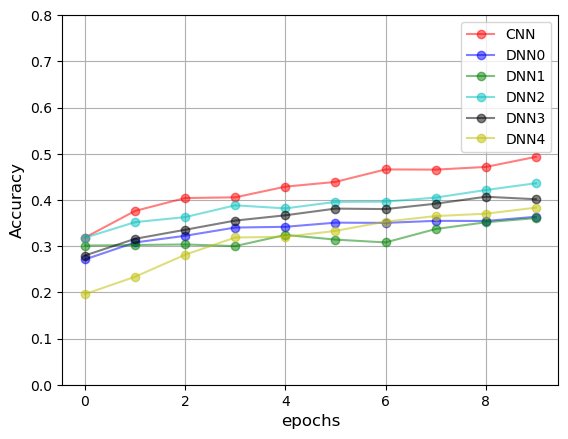

In [17]:
import matplotlib.pyplot as plt

plt.grid() 
plt.plot(range(epochs),Fit_CNN.history['val_accuracy'],'-or',alpha=0.5,label='CNN') 
plt.plot(range(epochs),Fit_hidden_layer_0.history['val_accuracy'],'-ob',alpha=0.5,label='DNN0') 
plt.plot(range(epochs),Fit_hidden_layer_1.history['val_accuracy'],'-og',alpha=0.5,label='DNN1') 
plt.plot(range(epochs),Fit_hidden_layer_2.history['val_accuracy'],'-oc',alpha=0.5,label='DNN2') 
plt.plot(range(epochs),Fit_hidden_layer_3.history['val_accuracy'],'-ok',alpha=0.5,label='DNN3') 
plt.plot(range(epochs),Fit_hidden_layer_4.history['val_accuracy'],'-oy',alpha=0.5,label='DNN4')
plt.ylim(0, 0.8)

plt.xlabel('epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
_=plt.legend(loc='best')


In [18]:
'''
Sigmoid activation function
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model_sigmoid = Sequential()
model_sigmoid.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
model_sigmoid.add(Activation('sigmoid'))
model_sigmoid.add(Conv2D(32, (3, 3)))
model_sigmoid.add(Activation('sigmoid'))
model_sigmoid.add(MaxPooling2D(pool_size=(2, 2)))
model_sigmoid.add(Dropout(0.25))

model_sigmoid.add(Conv2D(64, (3, 3), padding='same'))
model_sigmoid.add(Activation('sigmoid'))
model_sigmoid.add(Conv2D(64, (3, 3)))
model_sigmoid.add(Activation('sigmoid'))
model_sigmoid.add(MaxPooling2D(pool_size=(2, 2)))
model_sigmoid.add(Dropout(0.25))

model_sigmoid.add(Flatten())
model_sigmoid.add(Dense(512))
model_sigmoid.add(Activation('sigmoid'))
model_sigmoid.add(Dropout(0.5))
model_sigmoid.add(Dense(num_classes))
model_sigmoid.add(Activation('softmax'))

In [19]:
# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

model_sigmoid.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    model_sigmoid.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_CNN_sigmoid = model_sigmoid.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/10


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/3165154980.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_CNN_sigmoid = model_sigmoid.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 20s 199ms/step - loss: 2.3893 - accuracy: 0.0999 - val_loss: 2.3057 - val_accuracy: 0.1000
Epoch 2/10
98/98 [==============================] - 20s 202ms/step - loss: 2.3081 - accuracy: 0.0994 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 3/10
98/98 [==============================] - 20s 206ms/step - loss: 2.3042 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/10
98/98 [==============================] - 20s 201ms/step - loss: 2.3038 - accuracy: 0.1011 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 5/10
98/98 [==============================] - 20s 200ms/step - loss: 2.3038 - accuracy: 0.0994 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/10
98/98 [==============================] - 19s 194ms/step - loss: 2.3035 - accuracy: 0.0989 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/10
98/98 [==============================] - 20s 197ms/step - loss: 2.3034 - accuracy: 0.0991 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 8/10

In [20]:
'''
With drop out and augmentation
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

epochs = 100
data_augmentation = True

modeld1a1 = Sequential()
modeld1a1.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
modeld1a1.add(Activation('relu'))
modeld1a1.add(Conv2D(32, (3, 3)))
modeld1a1.add(Activation('relu'))
modeld1a1.add(MaxPooling2D(pool_size=(2, 2)))
modeld1a1.add(Dropout(0.25))

modeld1a1.add(Conv2D(64, (3, 3), padding='same'))
modeld1a1.add(Activation('relu'))
modeld1a1.add(Conv2D(64, (3, 3)))
modeld1a1.add(Activation('relu'))
modeld1a1.add(MaxPooling2D(pool_size=(2, 2)))
modeld1a1.add(Dropout(0.25))

modeld1a1.add(Flatten())
modeld1a1.add(Dense(512))
modeld1a1.add(Activation('relu'))
modeld1a1.add(Dropout(0.5))
modeld1a1.add(Dense(num_classes))
modeld1a1.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

modeld1a1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    modeld1a1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_CNN_d1a1 = modeld1a1.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/100


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/3974153860.py:88: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_CNN_d1a1 = modeld1a1.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 19s 187ms/step - loss: 2.1315 - accuracy: 0.2071 - val_loss: 1.8943 - val_accuracy: 0.3414
Epoch 2/100
98/98 [==============================] - 19s 190ms/step - loss: 1.8818 - accuracy: 0.3164 - val_loss: 1.7787 - val_accuracy: 0.3647
Epoch 3/100
98/98 [==============================] - 19s 187ms/step - loss: 1.7933 - accuracy: 0.3496 - val_loss: 1.7051 - val_accuracy: 0.3904
Epoch 4/100
98/98 [==============================] - 19s 193ms/step - loss: 1.7340 - accuracy: 0.3700 - val_loss: 1.6991 - val_accuracy: 0.3885
Epoch 5/100
98/98 [==============================] - 19s 188ms/step - loss: 1.6863 - accuracy: 0.3871 - val_loss: 1.6158 - val_accuracy: 0.4168
Epoch 6/100
98/98 [==============================] - 19s 195ms/step - loss: 1.6459 - accuracy: 0.4030 - val_loss: 1.5305 - val_accuracy: 0.4482
Epoch 7/100
98/98 [==============================] - 19s 194ms/step - loss: 1.6180 - accuracy: 0.4129 - val_loss: 1.4871 - val_accuracy: 0.4652
Epoc

98/98 [==============================] - 18s 185ms/step - loss: 1.0728 - accuracy: 0.6217 - val_loss: 0.9705 - val_accuracy: 0.6578
Epoch 58/100
98/98 [==============================] - 19s 188ms/step - loss: 1.0717 - accuracy: 0.6205 - val_loss: 0.9400 - val_accuracy: 0.6677
Epoch 59/100
98/98 [==============================] - 19s 191ms/step - loss: 1.0655 - accuracy: 0.6254 - val_loss: 0.9279 - val_accuracy: 0.6715
Epoch 60/100
98/98 [==============================] - 19s 188ms/step - loss: 1.0584 - accuracy: 0.6258 - val_loss: 0.9446 - val_accuracy: 0.6652
Epoch 61/100
98/98 [==============================] - 19s 187ms/step - loss: 1.0542 - accuracy: 0.6296 - val_loss: 0.9768 - val_accuracy: 0.6564
Epoch 62/100
98/98 [==============================] - 19s 187ms/step - loss: 1.0492 - accuracy: 0.6302 - val_loss: 1.0004 - val_accuracy: 0.6517
Epoch 63/100
98/98 [==============================] - 18s 185ms/step - loss: 1.0456 - accuracy: 0.6299 - val_loss: 0.9408 - val_accuracy: 0.669

In [21]:
'''
Without drop out and with augmentation
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

epochs = 100
data_augmentation = True

modeld0a1 = Sequential()
modeld0a1.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
modeld0a1.add(Activation('relu'))
modeld0a1.add(Conv2D(32, (3, 3)))
modeld0a1.add(Activation('relu'))
modeld0a1.add(MaxPooling2D(pool_size=(2, 2)))

modeld0a1.add(Conv2D(64, (3, 3), padding='same'))
modeld0a1.add(Activation('relu'))
modeld0a1.add(Conv2D(64, (3, 3)))
modeld0a1.add(Activation('relu'))
modeld0a1.add(MaxPooling2D(pool_size=(2, 2)))

modeld0a1.add(Flatten())
modeld0a1.add(Dense(512))
modeld0a1.add(Activation('relu'))
modeld0a1.add(Dense(num_classes))
modeld0a1.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

modeld0a1.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
    modeld0a1.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
  print('Using real-time data augmentation.')
  # This will do preprocessing and realtime data augmentation:
  datagen = ImageDataGenerator(
    featurewise_center=False, # set input mean to 0 over the dataset
    samplewise_center=False, # set each sample mean to 0
    featurewise_std_normalization=False, # divide inputs by std of the dataset
    samplewise_std_normalization=False, # divide each input by its std
    zca_whitening=False, # apply ZCA whitening
    zca_epsilon=1e-06, # epsilon for ZCA whitening
    rotation_range=0, # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0., # set range for random shear
    zoom_range=0., # set range for random zoom
    channel_shift_range=0., # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0., # value used for fill_mode = "constant"
    horizontal_flip=True, # randomly flip images
    vertical_flip=False, # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0)
  # Compute quantities required for feature-wise normalization
  # (std, mean, and principal components if ZCA whitening is applied).
  datagen.fit(x_train)

  # Fit the model on the batches generated by datagen.flow().
Fit_CNN_d0a1 = modeld0a1.fit_generator(datagen.flow(x_train, y_train,
                                 batch_size=batch_size),
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    workers=4)

Using real-time data augmentation.
Epoch 1/100


/var/folders/50/lvljp8zs01x6s7xzpqs95b2h0000gn/T/ipykernel_6198/1395830271.py:85: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  Fit_CNN_d0a1 = modeld0a1.fit_generator(datagen.flow(x_train, y_train,


98/98 [==============================] - 19s 187ms/step - loss: 1.9966 - accuracy: 0.2894 - val_loss: 1.8385 - val_accuracy: 0.3555
Epoch 2/100
98/98 [==============================] - 18s 186ms/step - loss: 1.7762 - accuracy: 0.3691 - val_loss: 1.6755 - val_accuracy: 0.4134
Epoch 3/100
98/98 [==============================] - 18s 183ms/step - loss: 1.6899 - accuracy: 0.3971 - val_loss: 1.5681 - val_accuracy: 0.4463
Epoch 4/100
98/98 [==============================] - 18s 187ms/step - loss: 1.6302 - accuracy: 0.4179 - val_loss: 1.5668 - val_accuracy: 0.4400
Epoch 5/100
98/98 [==============================] - 19s 187ms/step - loss: 1.5841 - accuracy: 0.4320 - val_loss: 1.5538 - val_accuracy: 0.4476
Epoch 6/100
98/98 [==============================] - 18s 180ms/step - loss: 1.5473 - accuracy: 0.4450 - val_loss: 1.5136 - val_accuracy: 0.4553
Epoch 7/100
98/98 [==============================] - 18s 180ms/step - loss: 1.5129 - accuracy: 0.4577 - val_loss: 1.4631 - val_accuracy: 0.4777
Epoc

98/98 [==============================] - 18s 181ms/step - loss: 0.9461 - accuracy: 0.6702 - val_loss: 0.9101 - val_accuracy: 0.6819
Epoch 58/100
98/98 [==============================] - 18s 178ms/step - loss: 0.9451 - accuracy: 0.6723 - val_loss: 0.8883 - val_accuracy: 0.6946
Epoch 59/100
98/98 [==============================] - 18s 181ms/step - loss: 0.9315 - accuracy: 0.6773 - val_loss: 0.9411 - val_accuracy: 0.6707
Epoch 60/100
98/98 [==============================] - 18s 179ms/step - loss: 0.9337 - accuracy: 0.6759 - val_loss: 0.8565 - val_accuracy: 0.7042
Epoch 61/100
98/98 [==============================] - 18s 180ms/step - loss: 0.9252 - accuracy: 0.6807 - val_loss: 0.9172 - val_accuracy: 0.6847
Epoch 62/100
98/98 [==============================] - 18s 181ms/step - loss: 0.9241 - accuracy: 0.6796 - val_loss: 0.9001 - val_accuracy: 0.6863
Epoch 63/100
98/98 [==============================] - 18s 181ms/step - loss: 0.9156 - accuracy: 0.6816 - val_loss: 0.8975 - val_accuracy: 0.688

In [23]:
'''
With drop out and without augmentation
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

epochs = 100
data_augmentation = False

modeld1a0 = Sequential()
modeld1a0.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
modeld1a0.add(Activation('relu'))
modeld1a0.add(Conv2D(32, (3, 3)))
modeld1a0.add(Activation('relu'))
modeld1a0.add(MaxPooling2D(pool_size=(2, 2)))
modeld1a0.add(Dropout(0.25))

modeld1a0.add(Conv2D(64, (3, 3), padding='same'))
modeld1a0.add(Activation('relu'))
modeld1a0.add(Conv2D(64, (3, 3)))
modeld1a0.add(Activation('relu'))
modeld1a0.add(MaxPooling2D(pool_size=(2, 2)))
modeld1a0.add(Dropout(0.25))

modeld1a0.add(Flatten())
modeld1a0.add(Dense(512))
modeld1a0.add(Activation('relu'))
modeld1a0.add(Dropout(0.5))
modeld1a0.add(Dense(num_classes))
modeld1a0.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

modeld1a0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
Fit_CNN_d1a0 = modeld1a0.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Not using data augmentation.
Epoch 1/100
98/98 [==============================] - 18s 181ms/step - loss: 2.1034 - accuracy: 0.2191 - val_loss: 1.9311 - val_accuracy: 0.3164
Epoch 2/100
98/98 [==============================] - 17s 178ms/step - loss: 1.8638 - accuracy: 0.3251 - val_loss: 1.7563 - val_accuracy: 0.3892
Epoch 3/100
98/98 [==============================] - 17s 177ms/step - loss: 1.7491 - accuracy: 0.3705 - val_loss: 1.6662 - val_accuracy: 0.4106
Epoch 4/100
98/98 [==============================] - 18s 181ms/step - loss: 1.6752 - accuracy: 0.3965 - val_loss: 1.5965 - val_accuracy: 0.4381
Epoch 5/100
98/98 [==============================] - 17s 176ms/step - loss: 1.6247 - accuracy: 0.4121 - val_loss: 1.5730 - val_accuracy: 0.4415
Epoch 6/100
98/98 [==============================] - 17s 175ms/step - loss: 1.5792 - accuracy: 0.4302 - val_loss: 1.4902 - val_accuracy: 0.4661
Epoch 7/100
98/98 [==============================] - 17s 178ms/step - loss: 1.5431 - accuracy: 0.4423 - val

98/98 [==============================] - 18s 180ms/step - loss: 0.8761 - accuracy: 0.6942 - val_loss: 0.8554 - val_accuracy: 0.7038
Epoch 58/100
98/98 [==============================] - 17s 173ms/step - loss: 0.8736 - accuracy: 0.6954 - val_loss: 0.8620 - val_accuracy: 0.6999
Epoch 59/100
98/98 [==============================] - 17s 176ms/step - loss: 0.8664 - accuracy: 0.6980 - val_loss: 0.8421 - val_accuracy: 0.7043
Epoch 60/100
98/98 [==============================] - 17s 174ms/step - loss: 0.8628 - accuracy: 0.6997 - val_loss: 0.8332 - val_accuracy: 0.7110
Epoch 61/100
98/98 [==============================] - 17s 178ms/step - loss: 0.8546 - accuracy: 0.7029 - val_loss: 0.8346 - val_accuracy: 0.7111
Epoch 62/100
98/98 [==============================] - 17s 175ms/step - loss: 0.8472 - accuracy: 0.7044 - val_loss: 0.8408 - val_accuracy: 0.7063
Epoch 63/100
98/98 [==============================] - 17s 173ms/step - loss: 0.8415 - accuracy: 0.7080 - val_loss: 0.8416 - val_accuracy: 0.711

In [24]:
'''
Without drop out and without augmentation
'''
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

epochs = 100
data_augmentation = False

modeld0a0 = Sequential()
modeld0a0.add(Conv2D(32, (3, 3), padding='same',
    input_shape=x_train.shape[1:]))
modeld0a0.add(Activation('relu'))
modeld0a0.add(Conv2D(32, (3, 3)))
modeld0a0.add(Activation('relu'))
modeld0a0.add(MaxPooling2D(pool_size=(2, 2)))

modeld0a0.add(Conv2D(64, (3, 3), padding='same'))
modeld0a0.add(Activation('relu'))
modeld0a0.add(Conv2D(64, (3, 3)))
modeld0a0.add(Activation('relu'))
modeld0a0.add(MaxPooling2D(pool_size=(2, 2)))

modeld0a0.add(Flatten())
modeld0a0.add(Dense(512))
modeld0a0.add(Activation('relu'))
modeld0a0.add(Dense(num_classes))
modeld0a0.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.legacy.RMSprop(learning_rate=0.0001, rho=0.9, epsilon=1e-08, decay=1e-6)

modeld0a0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
if not data_augmentation:
    print('Not using data augmentation.')
Fit_CNN_d0a0 = modeld0a0.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

Not using data augmentation.
Epoch 1/100
98/98 [==============================] - 17s 168ms/step - loss: 1.9908 - accuracy: 0.3001 - val_loss: 1.8013 - val_accuracy: 0.3684
Epoch 2/100
98/98 [==============================] - 16s 168ms/step - loss: 1.7309 - accuracy: 0.3882 - val_loss: 1.7364 - val_accuracy: 0.3965
Epoch 3/100
98/98 [==============================] - 17s 172ms/step - loss: 1.6270 - accuracy: 0.4214 - val_loss: 1.6228 - val_accuracy: 0.4223
Epoch 4/100
98/98 [==============================] - 17s 173ms/step - loss: 1.5560 - accuracy: 0.4465 - val_loss: 1.5393 - val_accuracy: 0.4420
Epoch 5/100
98/98 [==============================] - 17s 170ms/step - loss: 1.4985 - accuracy: 0.4681 - val_loss: 1.4959 - val_accuracy: 0.4725
Epoch 6/100
98/98 [==============================] - 17s 172ms/step - loss: 1.4602 - accuracy: 0.4811 - val_loss: 1.4191 - val_accuracy: 0.4935
Epoch 7/100
98/98 [==============================] - 17s 173ms/step - loss: 1.4263 - accuracy: 0.4927 - val

98/98 [==============================] - 18s 180ms/step - loss: 0.7048 - accuracy: 0.7608 - val_loss: 0.9247 - val_accuracy: 0.6845
Epoch 58/100
98/98 [==============================] - 17s 172ms/step - loss: 0.6949 - accuracy: 0.7630 - val_loss: 0.9190 - val_accuracy: 0.6857
Epoch 59/100
98/98 [==============================] - 17s 172ms/step - loss: 0.6877 - accuracy: 0.7651 - val_loss: 0.9357 - val_accuracy: 0.6816
Epoch 60/100
98/98 [==============================] - 17s 170ms/step - loss: 0.6754 - accuracy: 0.7695 - val_loss: 0.9397 - val_accuracy: 0.6827
Epoch 61/100
98/98 [==============================] - 16s 167ms/step - loss: 0.6676 - accuracy: 0.7746 - val_loss: 0.9086 - val_accuracy: 0.6899
Epoch 62/100
98/98 [==============================] - 17s 169ms/step - loss: 0.6576 - accuracy: 0.7765 - val_loss: 0.9474 - val_accuracy: 0.6802
Epoch 63/100
98/98 [==============================] - 17s 169ms/step - loss: 0.6487 - accuracy: 0.7787 - val_loss: 0.9657 - val_accuracy: 0.673

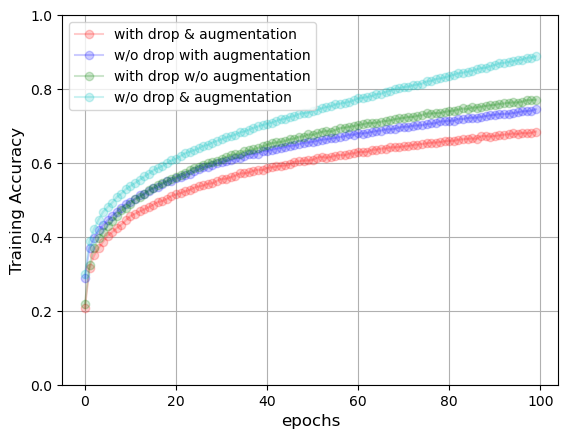

In [28]:
import matplotlib.pyplot as plt

plt.grid() 
plt.plot(range(epochs),Fit_CNN_d1a1.history['accuracy'],'-or',alpha=0.2,label='with drop & augmentation') 
plt.plot(range(epochs),Fit_CNN_d0a1.history['accuracy'],'-ob',alpha=0.2,label='w/o drop with augmentation') 
plt.plot(range(epochs),Fit_CNN_d1a0.history['accuracy'],'-og',alpha=0.2,label='with drop w/o augmentation') 
plt.plot(range(epochs),Fit_CNN_d0a0.history['accuracy'],'-oc',alpha=0.2,label='w/o drop & augmentation') 
plt.ylim(0, 1)

plt.xlabel('epochs',fontsize=12)
plt.ylabel('Training Accuracy',fontsize=12)
_=plt.legend(loc='best')

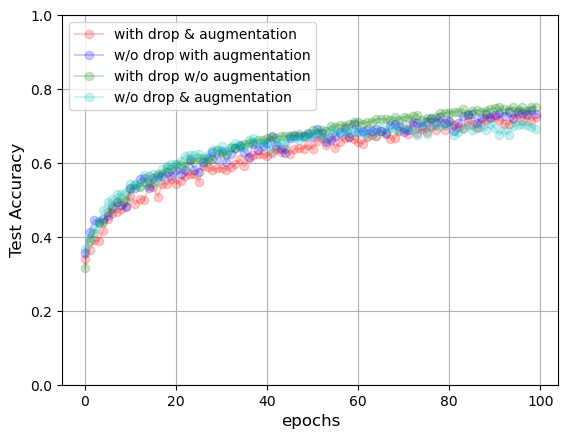

In [29]:
plt.grid() 
plt.plot(range(epochs),Fit_CNN_d1a1.history['val_accuracy'],'-or',alpha=0.2,label='with drop & augmentation') 
plt.plot(range(epochs),Fit_CNN_d0a1.history['val_accuracy'],'-ob',alpha=0.2,label='w/o drop with augmentation') 
plt.plot(range(epochs),Fit_CNN_d1a0.history['val_accuracy'],'-og',alpha=0.2,label='with drop w/o augmentation') 
plt.plot(range(epochs),Fit_CNN_d0a0.history['val_accuracy'],'-oc',alpha=0.2,label='w/o drop & augmentation') 
plt.ylim(0, 1)

plt.xlabel('epochs',fontsize=12)
plt.ylabel('Test Accuracy',fontsize=12)
_=plt.legend(loc='best')